In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, spearmanr, skew, pearsonr

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

#SMOTE
from imblearn.over_sampling import SMOTE

#Mô hình XG Boost
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier

import joblib

import optuna
from optuna.samplers import TPESampler
import catboost
from catboost import CatBoostClassifier

# **GIẢI THÍCH DỮ LIỆU:**

**1.Address:** Địa chỉ ví Bitcoin được sử dụng trong giao dịch.

**2.Year:** Năm diễn ra giao dịch.

**3.Day:** Ngày trong năm khi giao dịch được thực hiện.

**4.Length:** Độ dài của chuỗi giao dịch liên quan đến địa chỉ ví này.

**5.Weight:** Số liệu trọng số của giao dịch.

**6.Count:** Số lượng giao dịch được thực hiện bởi địa chỉ ví này.

**7.Looped:** Số lượng giao dịch mà địa chỉ ví đã gửi tiền trở lại cho chính nó.

**8.Neighbor:** Số lượng địa chỉ ví có liên kết trực tiếp với địa chỉ ví này trong các giao dịch.

**9.Income:** Tổng số lượng Bitcoin mà địa chỉ ví này đã nhận được.

**10.(OUTPUT) Label:** Nhãn phân loại cho địa chỉ. Các nhãn này gồm "white" (trong sạch), và các loại nhãn khác

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/bitcoinheistransomwareaddressdataset/BitcoinHeistData.csv')
data

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,1.000500e+08,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,1.000000e+08,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,2.000000e+08,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,7.120000e+07,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,2.000000e+08,princetonLocky
...,...,...,...,...,...,...,...,...,...,...
2916692,12D3trgho1vJ4mGtWBRPyHdMJK96TRYSry,2018,330,0,0.111111,1,0,1,1.255809e+09,white
2916693,1P7PputTcVkhXBmXBvSD9MJ3UYPsiou1u2,2018,330,0,1.000000,1,0,1,4.409699e+07,white
2916694,1KYiKJEfdJtap9QX2v9BXJMpz2SfU4pgZw,2018,330,2,12.000000,6,6,35,2.398267e+09,white
2916695,15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a,2018,330,0,0.500000,1,0,1,1.780427e+08,white


In [ ]:
#Không có dữ liệu Null
data.isnull().sum()

,0
address,0
year,0
day,0
length,0
weight,0
count,0
looped,0
neighbors,0
income,0
label,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [ ]:
data.describe()

,year,day,length,weight,count,looped,neighbors,income
count,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06
mean,2.014475e+03,1.814572e+02,4.500859e+01,5.455192e-01,7.216446e+02,2.385067e+02,2.206516e+00,4.464889e+09
std,2.257398e+00,1.040118e+02,5.898236e+01,3.674255e+00,1.689676e+03,9.663217e+02,1.791877e+01,1.626860e+11
min,2.011000e+03,1.000000e+00,0.000000e+00,3.606469e-94,1.000000e+00,0.000000e+00,1.000000e+00,3.000000e+07
25%,2.013000e+03,9.200000e+01,2.000000e+00,2.148438e-02,1.000000e+00,0.000000e+00,1.000000e+00,7.428559e+07
50%,2.014000e+03,1.810000e+02,8.000000e+00,2.500000e-01,1.000000e+00,0.000000e+00,2.000000e+00,1.999985e+08
75%,2.016000e+03,2.710000e+02,1.080000e+02,8.819482e-01,5.600000e+01,0.000000e+00,2.000000e+00,9.940000e+08
max,2.018000e+03,3.650000e+02,1.440000e+02,1.943749e+03,1.449700e+04,1.449600e+04,1.292000e+04,4.996440e+13


# **CHECKING**

***Có khá nhiều loại Ransomware tương đồng lẫn nhau, ta sẽ nhóm các loại này làm một để tin gọn output***

In [ ]:
def replace_labels(data):
  #Đổi tên các loại Ransomware cùng loại thành đòi tiền chuộc ('Blackmail Malicious Code'):
  values_to_replace_1 = ['princetonCerber', 'princetonLocky', 'montrealCryptoLocker', 'paduaCryptoWall',
                         'montrealDMALockerv3', 'montrealCryptoTorLocker2015', 'montrealSamSam', 'montrealFlyper',
                         'montrealNoobCrypt', 'montrealDMALocker', 'montrealGlobe', 'paduaKeRanger', 'montrealVenusLocker',
                         'montrealXTPLocker', 'paduaJigsaw', 'montrealGlobev3', 'montrealJigSaw', 'montrealXLockerv5.0',
                         'montrealXLocker', 'montrealRazy', 'montrealCryptConsole', 'montrealGlobeImposter', 'montrealSam',
                         'montrealComradeCircle']

  #Đổi tên các loại Ransomware cùng loại thành ăn cắp thông tin ('StealInforMaliciousCode'):
  values_to_replace_2 = ['montrealCryptXXX', 'montrealWannaCry', 'montrealEDA2', 'montrealAPT']

  # Thay thế các giá trị trong cột label
  data['label'] = data['label'].replace(values_to_replace_1, "BlackmailMaliciousCode")
  data['label'] = data['label'].replace(values_to_replace_2, "StealInforMaliciousCode")
  return data

data = replace_labels(data)

***Xử lý các giá trị outliers:***

*Dựa vào bảng describe, có vẻ như columns **weight**, **looped**, **neighbors** đang có nhiều giá trị này*

In [ ]:
skew_list = ['weight', 'looped', 'neighbors']

for i in skew_list:
  skewness = skew(data[i])
  print(f"Skewness của cột {i}:", skewness)

Skewness của cột weight: 243.01651434488195
Skewness của cột looped: 5.524710787477006
Skewness của cột neighbors: 293.5807868483756


In [ ]:
def IQR_outliers(data):
  #Tính toán IQR cho dữ liệu phân phối không chuẩn
  for i in skew_list:
    #tính toán IQR thông qua Q1,
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1

    # Xác định ngưỡng cho giá trị ngoại lệ
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Loại bỏ các giá trị ngoại lệ
    data = data[(data[i] >= lower_bound) & (data[i] <= upper_bound)]
  print("Dữ liệu sau khi loại bỏ Outliers sử dụng IQR:", data.shape)
  return data

data = IQR_outliers(data)

Dữ liệu sau khi loại bỏ Outliers sử dụng IQR: (2458342, 10)


In [ ]:
#Xóa đi 2 columns không còn cần thiết:
data = data.drop(columns = ['address', 'looped'])

# **EDA**

In [ ]:
df1 = data[data['label']=='white']
df2 = data[data['label']!='white']

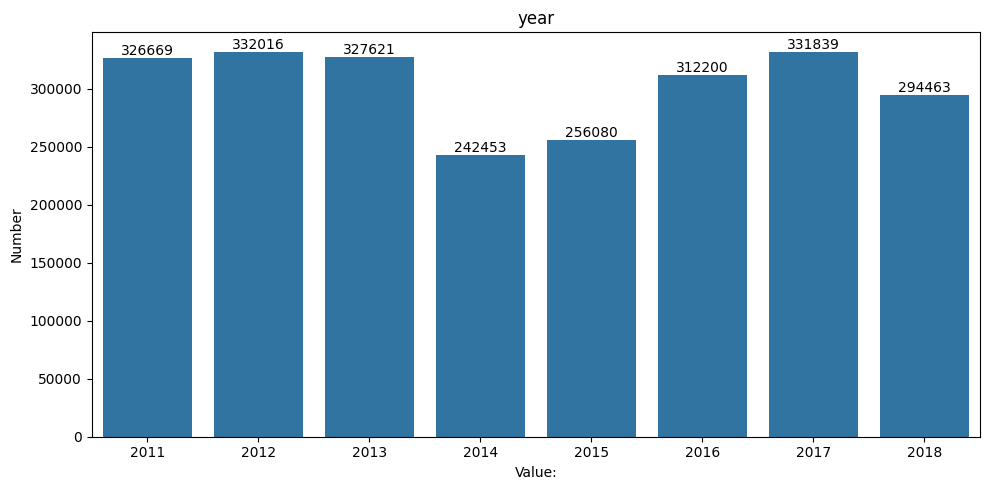

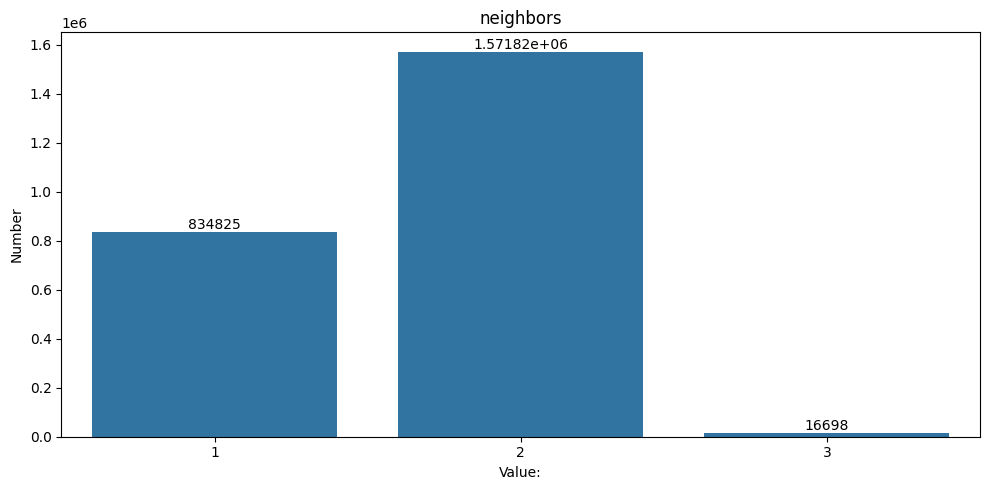

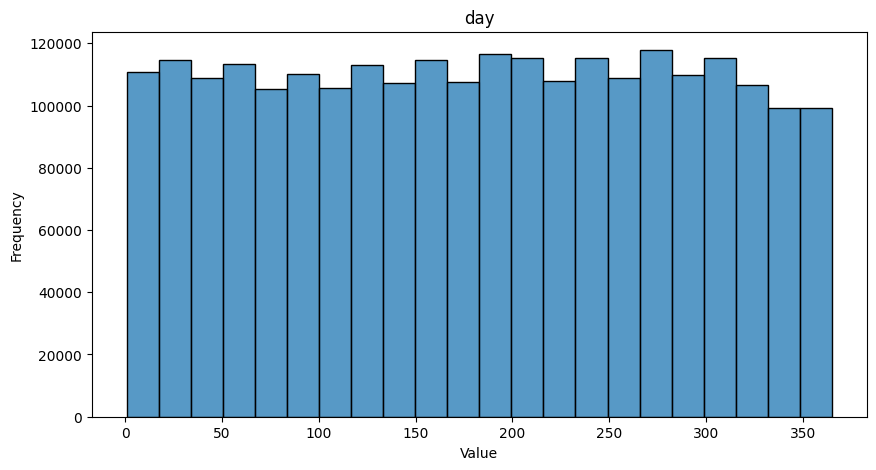

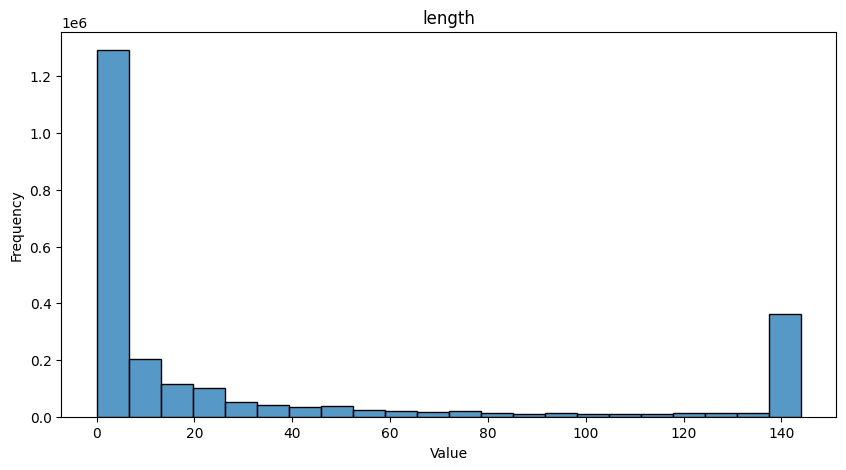

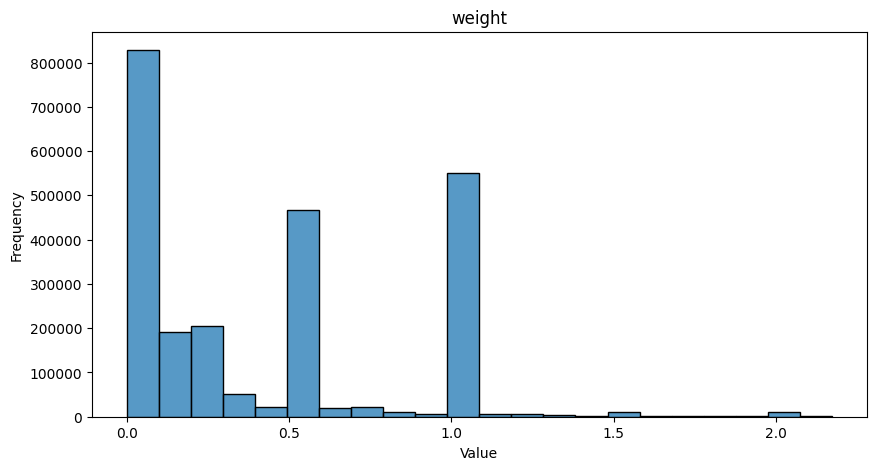

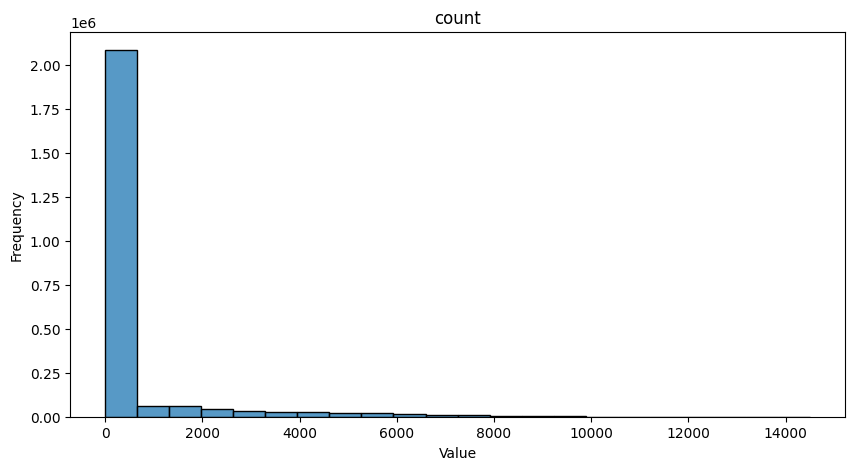

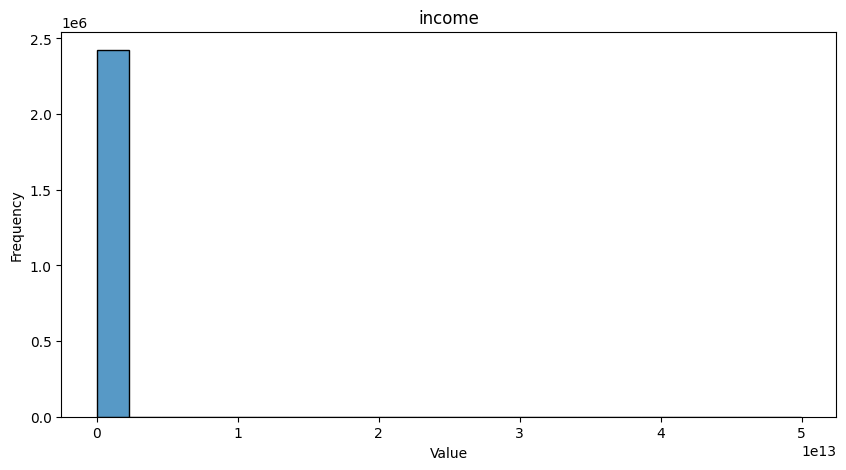

In [ ]:
bar_cols = ['year', 'neighbors']
hist_cols = ['day', 'length', 'weight', 'count', 'income']

for i in bar_cols:
  plt.figure(figsize=(10,5))
  ax1 = sns.barplot(x = df1[i].value_counts().index, y = df1[i].value_counts())
  ax1.set_xlabel('Value:')
  ax1.set_ylabel('Number')
  ax1.set_title(i)
  for container in ax1.containers:
    ax1.bar_label(container)
  plt.tight_layout()
  plt.show()

for i in hist_cols:
  plt.figure(figsize=(10,5))
  ax2 = sns.histplot(df1[i], bins=22)
  ax2.set_xlabel('Value')
  ax2.set_ylabel('Frequency')
  ax2.set_title(i)

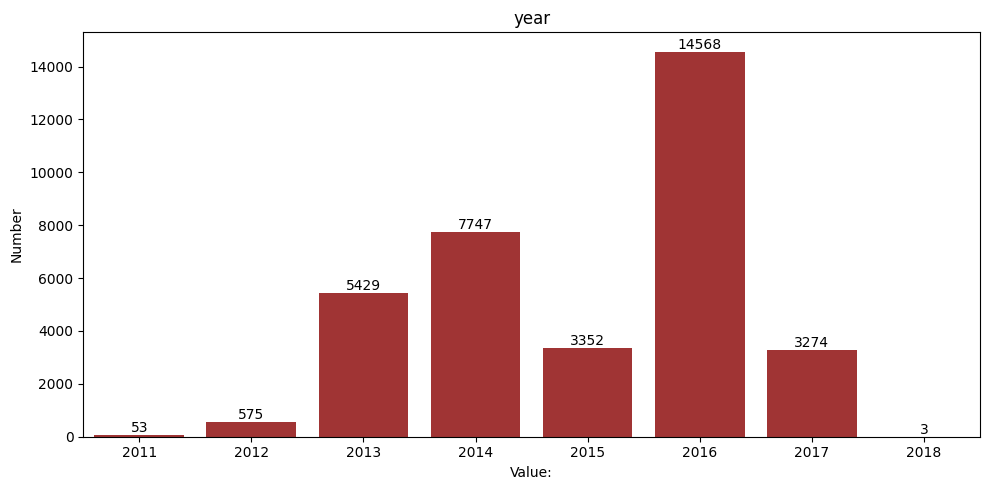

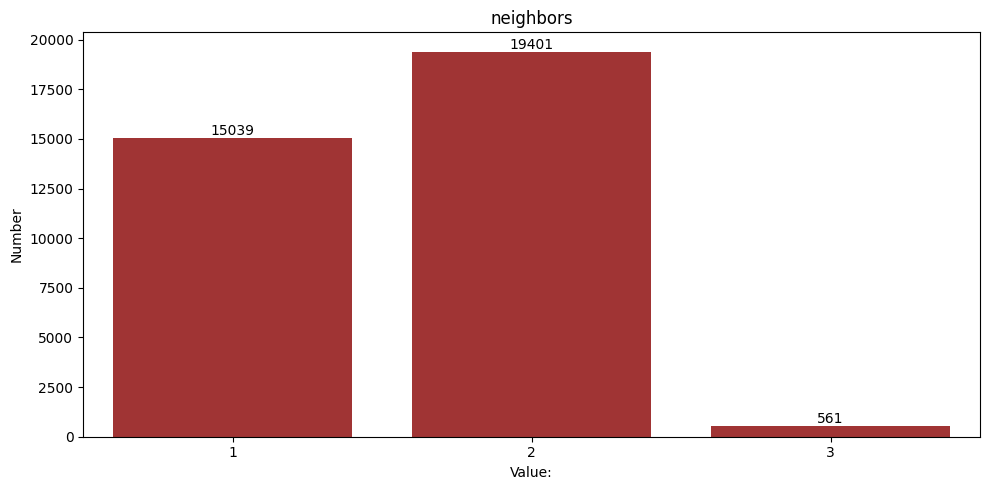

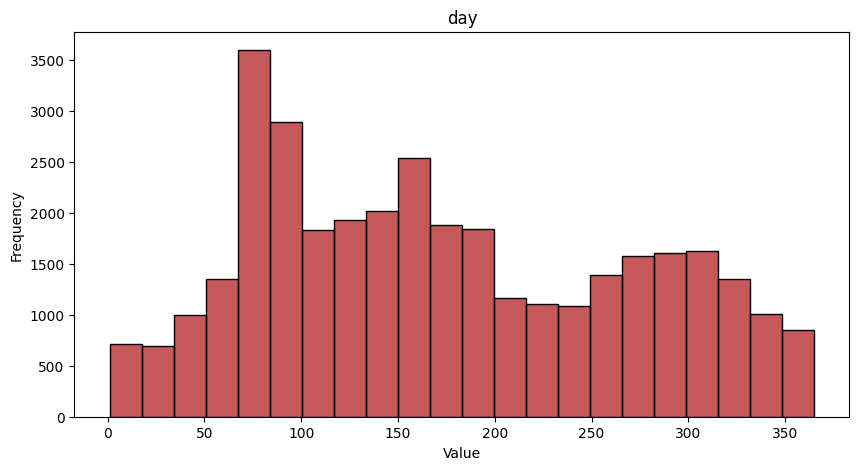

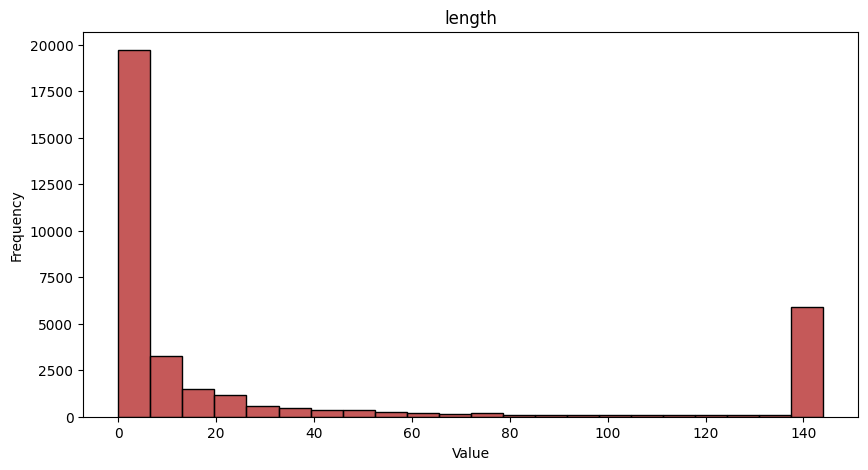

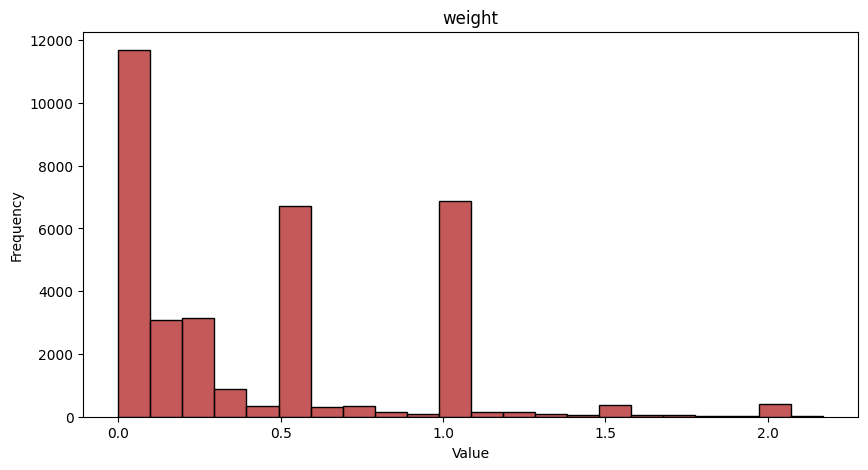

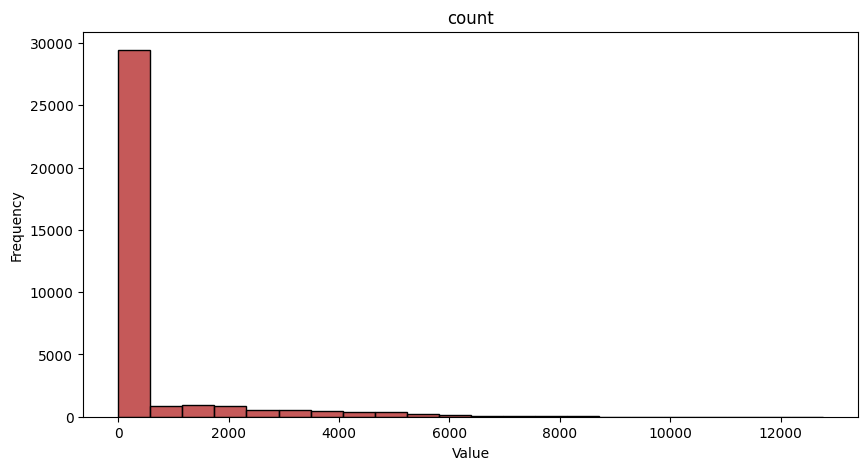

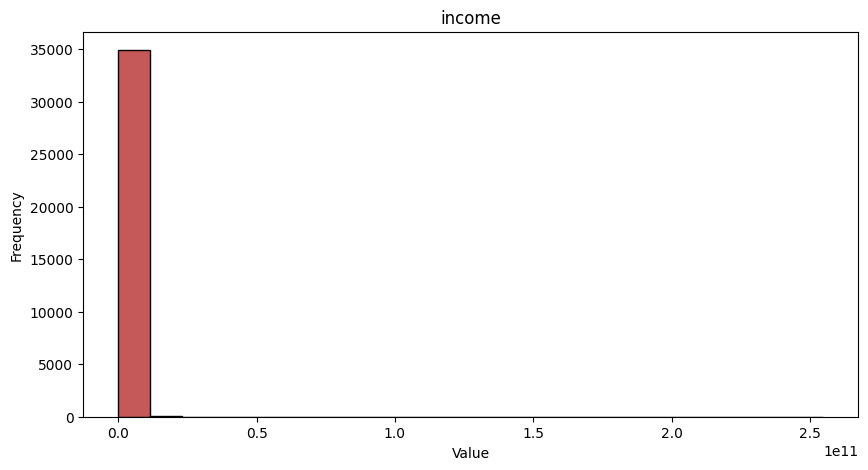

In [ ]:
bar_cols = ['year', 'neighbors']
hist_cols = ['day', 'length', 'weight', 'count', 'income']

for i in bar_cols:
  plt.figure(figsize=(10,5))
  ax1 = sns.barplot(x = df2[i].value_counts().index, y = df2[i].value_counts(), color='#B22222')
  ax1.set_xlabel('Value:')
  ax1.set_ylabel('Number')
  ax1.set_title(i)
  for container in ax1.containers:
    ax1.bar_label(container)
  plt.tight_layout()
  plt.show()

for i in hist_cols:
  plt.figure(figsize=(10,5))
  ax2 = sns.histplot(df2[i], bins=22, color='#B22222')
  ax2.set_xlabel('Value')
  ax2.set_ylabel('Frequency')
  ax2.set_title(i)

# **PREPROCESSING**

In [ ]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

***FEATURES SELECTION***

***1.Pearson Correlation để kiểm tra tuyến tính***

In [ ]:
pearson_cols = data.columns.drop(['label'])

for i in pearson_cols:
  corr, _ = pearsonr(data[i], data['label'])
  print(f"Pearson Correlation of column {i}:", corr)

Pearson Correlation of column year: -0.02708653701645771
Pearson Correlation of column day: 0.009066714464468013
Pearson Correlation of column length: 0.002465697740998113
Pearson Correlation of column weight: -0.0026465029490984047
Pearson Correlation of column count: 0.0004923511085608082
Pearson Correlation of column neighbors: 0.020368680015815686
Pearson Correlation of column income: 0.0029269944135760554


***2.Kiểm định Spearman cho các columns còn lại***

In [ ]:
df_cols = data.columns.to_list()
spearman_df = data[df_cols]
correlation_results = []

# Duyệt qua tất cả các cột trong DataFrame
for col in spearman_df.columns:
  if col == 'readmitted':
    continue
  else:
    if spearman_df[col].nunique() > 1:
      corr, p_value = spearmanr(spearman_df[col], spearman_df['label'])
      correlation_results.append((col, corr, p_value))
    else:
        print(f"Cột {col} có giá trị không thay đổi và bị bỏ qua.")

# Chuyển kết quả thành DataFrame để dễ quan sát
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Spearman Correlation', 'p-value'])
correlation_df = correlation_df.sort_values(by='Spearman Correlation', ascending=False)
correlation_df

,Feature,Spearman Correlation,p-value
7,label,1.000000,0.000000e+00
6,income,0.037124,0.000000e+00
5,neighbors,0.019510,1.510427e-205
1,day,0.009340,1.462133e-48
2,length,0.003541,2.820295e-08
4,count,-0.001118,7.971006e-02
3,weight,-0.002158,7.153031e-04
0,year,-0.028321,0.000000e+00


In [ ]:
data = data.drop(columns = ['count', 'weight', 'year'])

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,day,length,neighbors,income,label
day,1.000000,0.011917,0.000490,0.003465,0.009067
length,0.011917,1.000000,0.166412,0.001457,0.002466
neighbors,0.000490,0.166412,1.000000,0.007831,0.020369
income,0.003465,0.001457,0.007831,1.000000,0.002927
label,0.009067,0.002466,0.020369,0.002927,1.000000


# **PREDICTION**

***Lấy mẫu dữ liệu ngẫu nhiên, bao gồm toàn bộ mẫu của lớp số 0, 1 và khoảng 200000 mẫu 2***

In [ ]:
df_white = data[data['label']==2]
df_fraud = data[data['label']!=2]

df_white = df_white.sample(n=400000, random_state=42)

df = pd.concat([df_white, df_fraud])
df = df.sample(frac=1, random_state=42)

In [ ]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(data, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = data.drop(columns=['label'], axis=1)
    features = X.columns

    y = data['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    #Standard Scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(df)

***1.Random Forest và XG Boost thuần túy***

*Khá tốt, hiệu suất cao, và XGBOOST tốt hơn*

In [ ]:
model_RF = RandomForestClassifier(n_estimators=200, random_state=42, class_weight = 'balanced')
model_RF.fit(X_train, y_train)

y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     26311
           1       0.96      1.00      0.98      1760
           2       1.00      0.98      0.99    319929

    accuracy                           0.99    348000
   macro avg       0.94      0.99      0.96    348000
weighted avg       0.99      0.99      0.99    348000

              precision    recall  f1-score   support

           0       0.54      0.38      0.45      6519
           1       0.91      0.86      0.88       411
           2       0.95      0.97      0.96     80071

    accuracy                           0.93     87001
   macro avg       0.80      0.74      0.76     87001
weighted avg       0.92      0.93      0.92     87001



In [ ]:
model_XGB = xgb.XGBClassifier(n_estimators=200, random_state=42)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.76      0.29      0.42     26311
           1       0.87      0.88      0.87      1760
           2       0.94      0.99      0.97    319929

    accuracy                           0.94    348000
   macro avg       0.86      0.72      0.75    348000
weighted avg       0.93      0.94      0.93    348000

              precision    recall  f1-score   support

           0       0.71      0.27      0.39      6519
           1       0.84      0.82      0.83       411
           2       0.94      0.99      0.97     80071

    accuracy                           0.94     87001
   macro avg       0.83      0.69      0.73     87001
weighted avg       0.92      0.94      0.92     87001



***2.SMOTE với XG BOOST***

*Không ổn cho lắm, mặc dù recall được cải thiện tốt hơn hẳn, nhưng prediction bị giảm đi khá nhiều, hiệu suất bị giảm. SMOTE có thể vẫn là phương pháp hữu ích, nhưng cần kết hợp thêm nữa*

In [ ]:
# Áp dụng SMOTE để tăng cường lớp 1
class_counts = y_train.value_counts()
smote = SMOTE(sampling_strategy={0: class_counts[2], 1: class_counts[2]}, random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [ ]:
model_XGB_2 = xgb.XGBClassifier(n_estimators=200, random_state=42)
model_XGB_2.fit(X_train_resample, y_train_resample)

y_train_pred = model_XGB_2.predict(X_train_resample)
y_test_pred = model_XGB_2.predict(X_test)

print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77    319929
           1       0.96      0.99      0.97    319929
           2       0.79      0.73      0.76    319929

    accuracy                           0.84    959787
   macro avg       0.84      0.84      0.84    959787
weighted avg       0.84      0.84      0.84    959787

              precision    recall  f1-score   support

           0       0.18      0.67      0.28      6519
           1       0.21      0.92      0.34       411
           2       0.97      0.73      0.83     80071

    accuracy                           0.73     87001
   macro avg       0.45      0.77      0.48     87001
weighted avg       0.90      0.73      0.79     87001



***3.SMOTE kết hợp với CATBOOST***

In [ ]:
# Áp dụng SMOTE để tăng cường lớp 1
class_counts = y_train.value_counts()
smote = SMOTE(sampling_strategy={0: class_counts[2], 1: class_counts[2]}, random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [ ]:
def objective(trial):
  model_CB = CatBoostClassifier(
    iterations=trial.suggest_int("iterations", 100, 1000),
    learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
    depth=trial.suggest_int("depth", 4, 10),
    boosting_type=trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
    bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian", "MVS"]),
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
    random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
    bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
    od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
    od_wait=trial.suggest_int("od_wait", 10, 50),
    min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 51, 120),
    loss_function='Logloss',
    eval_metric='Logloss',
    task_type='CPU',  # Chạy trên CPU thay vì GPU
    verbose=False,
)

In [ ]:
# Tối ưu hóa hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-08-21 09:11:01,855] A new study created in memory with name: no-name-ed7385d3-5727-43c4-b1b8-8a8af3682420
[W 2024-08-21 09:11:01,862] Trial 0 failed with parameters: {'iterations': 516, 'learning_rate': 0.056938648117636506, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 1.996566052795429e-05, 'random_strength': 3.1720598598708875e-07, 'bagging_temperature': 6.6697580442676845, 'od_type': 'IncToDec', 'od_wait': 37, 'min_data_in_leaf': 113} because of the following error: The value None could not be cast to float..
[W 2024-08-21 09:11:01,865] Trial 0 failed with value None.
[W 2024-08-21 09:11:01,873] Trial 1 failed with parameters: {'iterations': 697, 'learning_rate': 0.009266023962870077, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 1.76064126169017e-08, 'random_strength': 0.001327894620444444, 'bagging_temperature': 3.0062905215164792, 'od_type': 'Iter', 'od_wait': 10, 'min_data_in_leaf': 70} because of the 

In [ ]:
best_params = {'iterations': 752, 'learning_rate': 0.0408087918563811, 'depth': 6,
               'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'l2_leaf_reg': 31.79561427141296,
               'random_strength': 2.1255689999362584e-07, 'bagging_temperature': 8.4080192147089,
               'od_type': 'Iter', 'od_wait': 44, 'min_data_in_leaf': 96}

In [ ]:
# Huấn luyện mô hình với hyperparameters tốt nhất
best_params = best_params
model_CB = CatBoostClassifier(**best_params)
model_CB.fit(X_train_resample, y_train_resample)

probs = model_CB.predict_proba(X_test)
y_train_pred = model_CB.predict(X_train_resample)
y_test_pred = model_CB.predict(X_test)

print(probs)
print(classification_report(y_train_resample, y_train_pred))
print(classification_report(y_test, y_test_pred))

0:	learn: 1.0633549	total: 2.61s	remaining: 32m 43s
1:	learn: 1.0317621	total: 5.15s	remaining: 32m 10s
2:	learn: 1.0032087	total: 8.86s	remaining: 36m 51s
3:	learn: 0.9768127	total: 12s	remaining: 37m 24s
4:	learn: 0.9530053	total: 14.4s	remaining: 35m 52s
5:	learn: 0.9304989	total: 16.8s	remaining: 34m 45s
6:	learn: 0.9119538	total: 19.2s	remaining: 34m 1s
7:	learn: 0.8923903	total: 22.1s	remaining: 34m 12s
8:	learn: 0.8741557	total: 26.1s	remaining: 35m 53s
9:	learn: 0.8571163	total: 28.5s	remaining: 35m 13s
10:	learn: 0.8482136	total: 30.9s	remaining: 34m 39s
11:	learn: 0.8382552	total: 33.3s	remaining: 34m 11s
12:	learn: 0.8243265	total: 35.6s	remaining: 33m 43s
13:	learn: 0.8108044	total: 39.2s	remaining: 34m 26s
14:	learn: 0.7974367	total: 42.6s	remaining: 34m 52s
15:	learn: 0.7854619	total: 44.9s	remaining: 34m 26s
16:	learn: 0.7726028	total: 47.3s	remaining: 34m 3s
17:	learn: 0.7619211	total: 49.6s	remaining: 33m 42s
18:	learn: 0.7513500	total: 52.1s	remaining: 33m 30s
19:	lea